In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

<h3 style=color:#3498db>///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////</h3>

<h3 style=color:#3498db>Load IMDB Reviews</h3>

In [3]:
# Download the plain text dataset
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

# Get the train and test sets
train_data, test_data = imdb['train'], imdb['test']


# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []


# Loop over all training examples and save the sentences and labels
for s,l in train_data:
    training_sentences.append(s.numpy().decode('utf8'))
    training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s,l in test_data:
    testing_sentences.append(s.numpy().decode('utf8'))
    testing_labels.append(l.numpy())


# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

<h3 style=color:#3498db>Tokenize And Padding</h3>

In [4]:
# Parameters
vocab_size = 10000
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

<h3 style=color:#3498db>Plot Loss and Accuracy Function</h3>

In [5]:
def plot_loss_accuracy(modelhistory, modelname):
    
    loss     = modelhistory.history['loss']
    val_loss = modelhistory.history['val_loss']
    acc      = modelhistory.history['accuracy']
    val_acc  = modelhistory.history['val_accuracy']

    epochs   = range(1,len(acc)+1) # Get number of epochs

    plt.style.use('seaborn')
    
    # Create Subplots System
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)

    # Change Figure Size
    fig.set_size_inches(12, 6)

    # Fig Name
    fig.suptitle(modelname, fontsize=18)
    
    # First Axies
    ax1.plot(epochs, loss, label="Training Loss")
    ax1.plot(epochs, val_loss, label="Validation Loss")
    ax1.set_title('Loss')
    ax1.set_xlim(0,len(acc)+1)
    ax1.set_ylim(0,1.0)
    ax1.legend()

    # Second Axies
    ax2.plot(epochs, acc, label="Training Accuracy")
    ax2.plot(epochs, val_acc, label="Validation Accuracy")
    ax2.set_title('Accuracy')
    ax2.set_xlim(0,len(acc)+1)
    ax2.legend()

    # Change Padding to Tight
    plt.tight_layout()

    # Show The Figure
    plt.show()

<h3 style=color:#3498db>///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////</h3>

<h1 style=color:#3498db>Model 1: Flatten</h1>

In [6]:
def create_flatten_model():
    
    # Parameters
    embedding_dim = 16
    dense_dim = 6

    # Model Definition with a Flatten layer
    model = keras.Sequential([
        
                              layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                              layers.Flatten(),
        
                              layers.Dense(dense_dim, activation='relu'),
                              layers.Dense(1, activation='sigmoid')
        
                              ])

    # Set the training parameters
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    # Print the model summary
    return model

In [7]:
flatten_model = create_flatten_model()
flatten_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [8]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
flatten_history = flatten_model.fit(
                                    padded,
                                    training_labels_final,
                                    batch_size=BATCH_SIZE,
                                    epochs=NUM_EPOCHS,
                                    validation_data=(testing_padded, testing_labels_final)
                                    )

Epoch 1/10
196/196 [==============================] - 6s 9ms/step - loss: 0.5998 - accuracy: 0.6676 - val_loss: 0.3923 - val_accuracy: 0.8288
Epoch 2/10
196/196 [==============================] - 2s 9ms/step - loss: 0.3105 - accuracy: 0.8727 - val_loss: 0.3370 - val_accuracy: 0.8517
Epoch 3/10
196/196 [==============================] - 2s 9ms/step - loss: 0.1992 - accuracy: 0.9285 - val_loss: 0.3508 - val_accuracy: 0.8483
Epoch 4/10
196/196 [==============================] - 2s 8ms/step - loss: 0.1127 - accuracy: 0.9707 - val_loss: 0.3931 - val_accuracy: 0.8392
Epoch 5/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0532 - accuracy: 0.9931 - val_loss: 0.4460 - val_accuracy: 0.8327
Epoch 6/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0248 - accuracy: 0.9983 - val_loss: 0.4809 - val_accuracy: 0.8330
Epoch 7/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0133 - accuracy: 0.9992 - val_loss: 0.5158 - val_accuracy: 0.8319
Epoch 

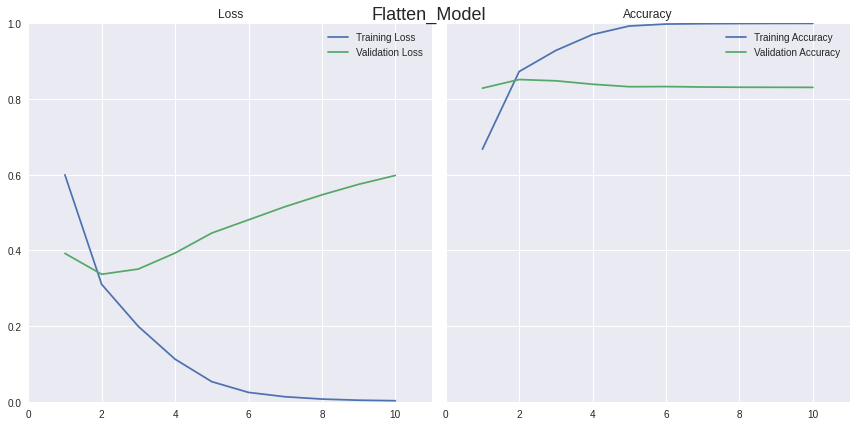

In [9]:
flatten_name = 'Flatten_Model'
plot_loss_accuracy(flatten_history,flatten_name)

<h3 style=color:#3498db>///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////</h3>

<h1 style=color:#3498db>Model 2: LSTM</h1>

In [10]:
def create_lstm_model():
    
    # Parameters
    embedding_dim = 16
    lstm_dim = 32
    dense_dim = 6

    # Model Definition with LSTM
    model = keras.Sequential([
        
                              layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        
                              layers.Bidirectional(layers.LSTM(lstm_dim)),
        
                              layers.Dense(dense_dim, activation='relu'),
                              layers.Dense(1, activation='sigmoid')
        
                              ])

    # Set the training parameters
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    return model

In [11]:
lstm_model = create_lstm_model()
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [12]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
lstm_history = lstm_model.fit(
                             padded,
                             training_labels_final,
                             batch_size=BATCH_SIZE,
                             epochs=NUM_EPOCHS,
                             validation_data=(testing_padded, testing_labels_final)
                             )

Epoch 1/10
196/196 [==============================] - 19s 70ms/step - loss: 0.5798 - accuracy: 0.6670 - val_loss: 0.4187 - val_accuracy: 0.8312
Epoch 2/10
196/196 [==============================] - 13s 65ms/step - loss: 0.3284 - accuracy: 0.8630 - val_loss: 0.3854 - val_accuracy: 0.8199
Epoch 3/10
196/196 [==============================] - 13s 65ms/step - loss: 0.2552 - accuracy: 0.9004 - val_loss: 0.3722 - val_accuracy: 0.8401
Epoch 4/10
196/196 [==============================] - 13s 66ms/step - loss: 0.2130 - accuracy: 0.9215 - val_loss: 0.3915 - val_accuracy: 0.8345
Epoch 5/10
196/196 [==============================] - 13s 65ms/step - loss: 0.1847 - accuracy: 0.9325 - val_loss: 0.4387 - val_accuracy: 0.8284
Epoch 6/10
196/196 [==============================] - 13s 65ms/step - loss: 0.1520 - accuracy: 0.9491 - val_loss: 0.4861 - val_accuracy: 0.8171
Epoch 7/10
196/196 [==============================] - 13s 65ms/step - loss: 0.1238 - accuracy: 0.9611 - val_loss: 0.5726 - val_accuracy:

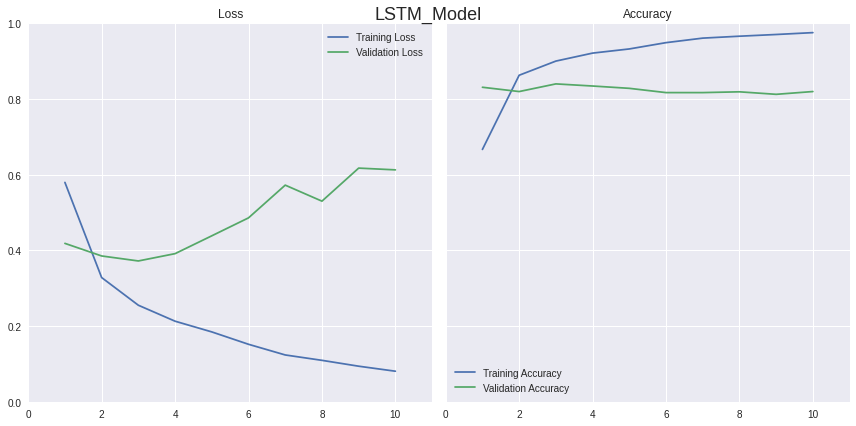

In [13]:
lstm_name = 'LSTM_Model'
plot_loss_accuracy(lstm_history,lstm_name)

<h3 style=color:#3498db>///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////</h3>

<h1 style=color:#3498db>Model 3: GRU</h1>

In [17]:
def create_gru_model():
    
    # Parameters
    embedding_dim = 16
    gru_dim = 32
    dense_dim = 6

    # Model Definition with GRU
    model = keras.Sequential([
        
                                  layers.Embedding(vocab_size, embedding_dim, input_length=max_length),

                                  layers.Bidirectional(layers.GRU(gru_dim)),

                                  layers.Dense(dense_dim, activation='relu'),
                                  layers.Dense(1, activation='sigmoid')

                                  ])

    # Set the training parameters
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    return model

In [19]:
gru_model = create_gru_model()
gru_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 6)                 390       
                                                                 
 dense_11 (Dense)            (None, 1)                 7         
                                                                 
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [20]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
gru_hisroy  = gru_model.fit(
                            padded,
                            training_labels_final,
                            batch_size=BATCH_SIZE,
                            epochs=NUM_EPOCHS,
                            validation_data=(testing_padded, testing_labels_final)
                            )

Epoch 1/10
196/196 [==============================] - 17s 68ms/step - loss: 0.5947 - accuracy: 0.6401 - val_loss: 0.3664 - val_accuracy: 0.8424
Epoch 2/10
196/196 [==============================] - 12s 64ms/step - loss: 0.3212 - accuracy: 0.8670 - val_loss: 0.3408 - val_accuracy: 0.8542
Epoch 3/10
196/196 [==============================] - 12s 64ms/step - loss: 0.2439 - accuracy: 0.9054 - val_loss: 0.3920 - val_accuracy: 0.8383
Epoch 4/10
196/196 [==============================] - 12s 64ms/step - loss: 0.1885 - accuracy: 0.9314 - val_loss: 0.4104 - val_accuracy: 0.8414
Epoch 5/10
196/196 [==============================] - 13s 64ms/step - loss: 0.1592 - accuracy: 0.9439 - val_loss: 0.4428 - val_accuracy: 0.8360
Epoch 6/10
196/196 [==============================] - 12s 64ms/step - loss: 0.1233 - accuracy: 0.9579 - val_loss: 0.5482 - val_accuracy: 0.8285
Epoch 7/10
196/196 [==============================] - 13s 64ms/step - loss: 0.1017 - accuracy: 0.9658 - val_loss: 0.5451 - val_accuracy:

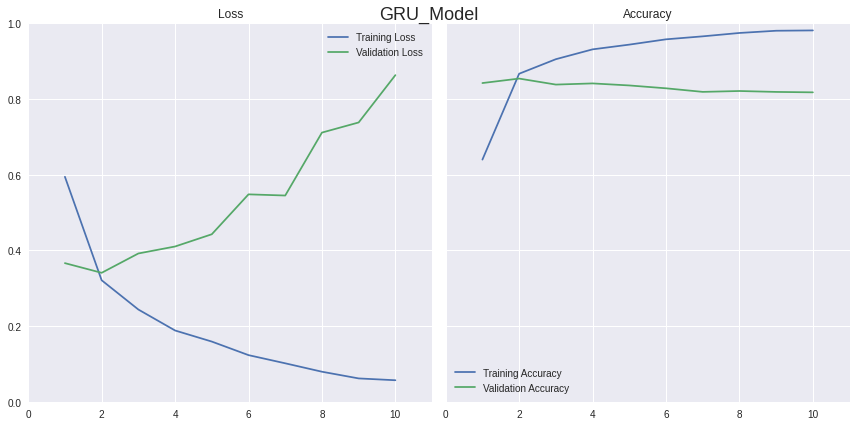

In [21]:
gru_name = "GRU_Model"
plot_loss_accuracy(gru_hisroy,gru_name)

<h3 style=color:#3498db>///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////</h3>

<h1 style=color:#3498db>Model 4: Convolution</h1>

In [22]:
def create_convolution_model():
    
    # Parameters
    embedding_dim = 16
    filters = 128
    kernel_size = 5
    dense_dim = 6

    # Model Definition with Conv1D
    model = keras.Sequential([
        
                              layers.Embedding(vocab_size, embedding_dim, input_length=max_length),

                              layers.Conv1D(filters, kernel_size, activation='relu'),
                              layers.GlobalAveragePooling1D(),

                              layers.Dense(dense_dim, activation='relu'),
                              layers.Dense(1, activation='sigmoid')

                              ])

    # Set the training parameters
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    return model

In [23]:
convolution_model = create_convolution_model()
convolution_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_12 (Dense)            (None, 6)                 774       
                                                                 
 dense_13 (Dense)            (None, 1)                 7         
                                                                 
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
________________________________________________

In [24]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
convolution_history  = convolution_model.fit(
                                             padded,
                                             training_labels_final,
                                             batch_size=BATCH_SIZE,
                                             epochs=NUM_EPOCHS,
                                             validation_data=(testing_padded, testing_labels_final)
                                             )

Epoch 1/10
196/196 [==============================] - 10s 14ms/step - loss: 0.5655 - accuracy: 0.6832 - val_loss: 0.3660 - val_accuracy: 0.8400
Epoch 2/10
196/196 [==============================] - 3s 15ms/step - loss: 0.3131 - accuracy: 0.8705 - val_loss: 0.3474 - val_accuracy: 0.8472
Epoch 3/10
196/196 [==============================] - 2s 12ms/step - loss: 0.2498 - accuracy: 0.8999 - val_loss: 0.3646 - val_accuracy: 0.8456
Epoch 4/10
196/196 [==============================] - 2s 13ms/step - loss: 0.2139 - accuracy: 0.9181 - val_loss: 0.4171 - val_accuracy: 0.8291
Epoch 5/10
196/196 [==============================] - 3s 16ms/step - loss: 0.1881 - accuracy: 0.9312 - val_loss: 0.4371 - val_accuracy: 0.8316
Epoch 6/10
196/196 [==============================] - 3s 16ms/step - loss: 0.1668 - accuracy: 0.9409 - val_loss: 0.4968 - val_accuracy: 0.8184
Epoch 7/10
196/196 [==============================] - 3s 16ms/step - loss: 0.1467 - accuracy: 0.9500 - val_loss: 0.5136 - val_accuracy: 0.820

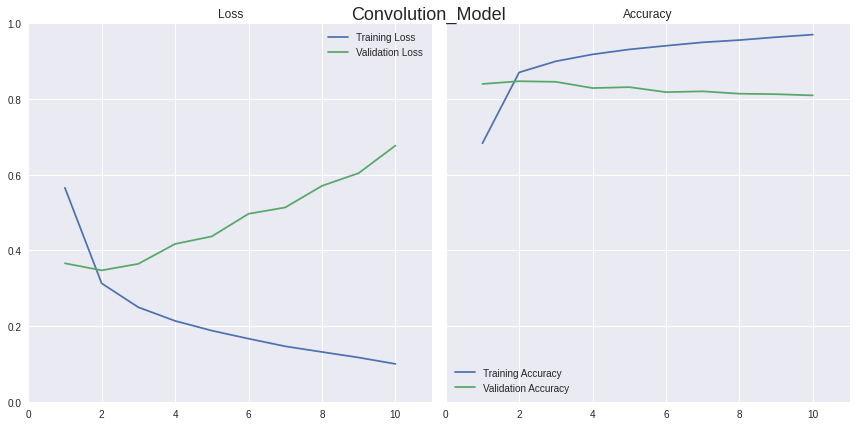

In [25]:
convolution_name = "Convolution_Model"
plot_loss_accuracy(convolution_history,convolution_name)

<h3 style=color:#3498db>///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////</h3>